<center><h1 style="font-size:40px;">Project 3<br>Object detection</h1></center>

---

This project will develop an object detection system with **Single-shot multibox detectors (SSD)**. The task is to use the [COCO](https://cocodataset.org) dataset to predict bounding boxes.  

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

Good luck!

---

# Task

**TODO:** Implement **SSD** to predict bounding boxes on the training set.

**TODO:** Select a good metric to evaluate the models performance and argue why the metric give a good overview of the performance.

**TODO:** Is it possible to reduce the number of bounding boxes? If yes, implement it and why it is a good solution.


**Question:** Explain in the report what you did and why. Present a pipeline of the code. 

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
from config import LabConfig
import torchmetrics
import transforms as T
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np

import zipfile

#from utils.dataset import CocoDataset
from utils.plot import Detection

In [5]:
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [3]:
if torch.cuda.is_available():
  print("GPU available")

GPU available


In [4]:
dataset_path = './input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/'
train_im_path = dataset_path + 'images/train/'
train_label_path = dataset_path + 'labels/train/'

test_im_path = dataset_path + 'images/test/'
test_label_path = dataset_path + 'labels/test/'


In [5]:
train_images = os.listdir(train_im_path)
train_labels = os.listdir(train_label_path)
test_images = os.listdir(test_im_path)
test_labels = os.listdir(test_label_path)

311
297
137
00124_12.jpg
137
00350_128.txt
311
297
46
00350_128.jpg
46
00253_79.txt
311
297
88
00099_145.jpg
88
00313_124.txt
311
297
66
00304_107.jpg
66
00291_23.txt
311
297
217
00334_121.jpg
217
00246_103.txt
311
297
242
00123_13.jpg
242
00260_119.txt
311
297
63
00322_121.jpg
63
00158_115.txt
311
297
121
00176_92.jpg
121
00124_9.txt
311
297
241
00151_10.jpg
241
00124_8.txt
311
297
160
00294_23.jpg
160
00123_12.txt


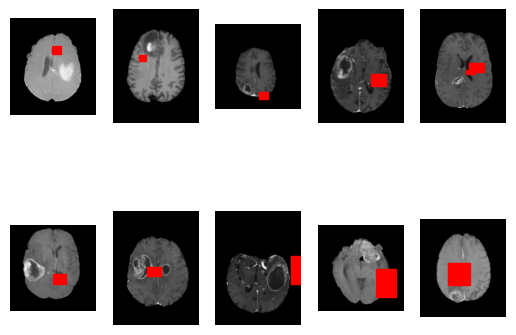

In [76]:
plt.Figure(figsize=(100,50))
for i, c in enumerate(np.random.randint(0, len(train_images), size=10), start=1):
    ax=plt.subplot(2,5,i)
    #fig,ax = plt.subplots()
    im = plt.imread(train_im_path+train_images[c])
    im_sz_x,im_sz_y = im.shape
    plt.axis('off')
    plt.imshow(im, cmap='gray')
    print(len(train_images))
    print(len(train_labels))
    print(c)
    print(train_images[c])
    print(c)
    print(train_labels[c])
    filename = train_label_path+train_labels[c]
    with open(filename) as f:
        lines = f.readlines()
        lines = [line.split() for line in lines]
    f.close()
    for line in lines:
        # Create a Rectangle patch
        line = [float(num) for num in line]
        bb_true = patches.Rectangle((line[1]*im_sz_x, line[2]*im_sz_y), line[3]*im_sz_x, line[4]*im_sz_y, linewidth=1, edgecolor='r', facecolor='r')
        # Add the patch to the Axes
        ax.add_patch(bb_true)
        

## Load config
Note that this lab does not support for fineGrained dataset.

In [ ]:
cfg = LabConfig()
cfg.todict()

# Dataset
Coco contain a wide variety of images and the corresponding annotation. To download the dataset we use aria2 and the script found in *download.sh*. Note that the dataset is quite large so we need plenty of space on the hard drive.

Change code below to True if you want to download the data. Dont forget to change back since it will download the data each time you run the full notebook.

In [ ]:
if False:
    !sh ./download.sh $cfg.COCO_DATASET

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.SquarePad(480, 640)
])
test_transform = T.Compose([
    T.ToTensor(),
    T.SquarePad(480, 640)
])

## Dataloader

In [ ]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(
    CocoDataset(
        root=cfg.training_img_dir,
        annotation=cfg.training_annotations,
        transforms=train_transform
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collate_fn)

validation_dataloader = torch.utils.data.DataLoader(
    CocoDataset(
        root=cfg.validation_img_dir,
        annotation=cfg.validation_annotations,
        transforms=train_transform
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collate_fn)

## Visualisations

Print the following to get an idea of the different categories

In [ ]:
cats = train_dataloader.dataset.coco.loadCats(coco_dataset.coco.getCatIds())
", ".join([cat['name'] for cat in cats])

To get an idea of what bounding boxes are we can plot a subset of the dataset. Each color represent a class which we can access through the variable *t_y*. We use colors to get an idea of different objects in order to separate them from each other.

In [ ]:
t_x, t_y = next(iter(train_dataloader))

In [ ]:
Detection.data(t_x, t_y, max(coco_dataset.coco.cats.keys()), plot_kwargs={'nimages':10}, width=5, font_size=30)

# Implementation

---